### **Simulation: sparse high-dimensional quantile regression**
This code accompanies the paper:<br>
*Convergence for nonconvex ADMM, with applications to CT imaging.*<br>
Rina Foygel Barber and Emil Y. Sidky. [arXiv:2006.07278](http://arxiv.org/abs/2006.07278)<br>

#### **Setting:**

Data: for each data point $i=1,\dots,n$, we observe:
* Response $w_i\in\mathbb{R}$,
* Feature vector $\phi_i \in\mathbb{R}^d$.

Goal: find $x\in\mathbb{R}^d$ such that $\phi_i^\top x$ estimates the $q$-quantile of the distribution of $w_i$.

#### **Minimization problem:**

$$\min_{x\in\mathbb{R}^d}\left\{\frac{1}{n}\sum_{i=1}^n \ell_q(w_i - \phi_i^\top x) + \lambda\sum_{j=1}^d\beta\log(1+|x_j|/\beta)\right\}$$
where $\ell_q$ is the $q$-quantile loss:
$$\ell_q(t) = q\cdot\max\{t,0\} + (1-q)\cdot\max\{-t,0\}.$$

#### **Reformulate for nonconvex ADMM:**

We introduce a new variable $y=\Phi x$ (where $\Phi\in\mathbb{R}^{n\times d}$ has rows $\phi_i$).
The minimization problem is now the following:
$$\min_{\substack{x\in\mathbb{R}^d\\y\in\mathbb{R}^n}}\left\{\frac{1}{n}\sum_{i=1}^n \ell_q(w_i - y_i) + \lambda\sum_{j=1}^d\beta\log(1+|x_j|/\beta) \ : \ \Phi x = y\right\}.$$

Move to augmented Lagrangian form:
$$\min_{\substack{x\in\mathbb{R}^d\\y\in\mathbb{R}^n}}\max_{u\in\mathbb{R}^n}\left\{\frac{1}{n}\sum_{i=1}^n \ell_q(w_i - y_i) + \lambda\sum_{j=1}^d\beta\log(1+|x_j|/\beta) + \langle u, \Phi x - y\rangle + \frac{\sigma}{2}\|\Phi x - y\|^2_2\right\}.$$

Moving to the notation of the paper, to apply the nonconvex ADMM algorithm with linear approximations, first define functions:
$$f_c(x) = \lambda\sum_{j=1}^d|x_j|, \ \ \ f_d(x) = \lambda\sum_{j=1}^d \Big(\beta \log(1+|x_j|/\beta) - |x_j|\Big), \ \ \ g_c(y) = \frac{1}{n}\sum_{i=1}^n \ell_q(w_i - y_i), \ \ \ g_d(y)\equiv 0,$$
and step size matrices
$H_f = \sigma\left(\gamma\mathbf{I}_d - \Phi^\top \Phi\right)$
and $H_g = 0$, where $\gamma = \|\Phi\|^2$. The update steps of the algorithm are calculated explicitly in the paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1234)

In [2]:
n = 2000
d = 2500
lam = 0.1
beta = 0.5
sig_grid = np.array([0.00005,0.0001,0.0002,0.0005]) # ADMM parameter
nsig = len(sig_grid)
niter = 1000
q = 0.5
df = 5 # noise distribution

# construct true signal
s_true = 10
amp_true = 1
x_true = np.r_[amp_true*np.ones(s_true),np.zeros(d-s_true)]

# objective function
def loss(x):
    return 1/n*(np.maximum(w-Phi.dot(x),0).sum()*q + np.maximum(Phi.dot(x)-w,0).sum()*(1-q))\
            + lam*beta*np.log(1+np.abs(x)/beta).sum()

In [3]:
# generate data
Phi = np.random.normal(size=(n,d))
w = Phi.dot(x_true) + np.random.standard_t(df,size=n)
gam = np.linalg.svd(Phi,compute_uv=0).max()**2

# run algorithm
loss_xt = np.zeros((niter,nsig))
loss_xtbar = np.zeros((niter,nsig))
rmse_xt = np.zeros((niter,nsig))
rmse_xtbar = np.zeros((niter,nsig))
for isig in range(nsig):
    sig = sig_grid[isig]
    x_avg = np.zeros(d)
    x = np.zeros(d)
    y = np.zeros(n)
    u = np.zeros(n)
    for i in range(niter):
        x = x - Phi.T.dot(Phi.dot(x))/gam + Phi.T.dot(y)/gam - Phi.T.dot(u)/sig/gam \
                + lam * x/(beta+np.abs(x))/sig/gam
        x = np.sign(x) * np.maximum(np.abs(x)-lam/sig/gam,0)
        y = Phi.dot(x) + u/sig
        y = (y + q/n/sig)*(y+q/n/sig<w) + (y-(1-q)/n/sig)*(y-(1-q)/n/sig>w)\
                + w*(y+q/n/sig>=w)*(y-(1-q)/n/sig<=w)
        u = u + sig*(Phi.dot(x)-y)
        x_avg = x_avg*(i/(i+1)) + x*(1/(i+1))
        loss_xt[i,isig] = loss(x)
        loss_xtbar[i,isig] = loss(x_avg)
        rmse_xt[i,isig] = np.sqrt(np.mean((x-x_true)**2))
        rmse_xtbar[i,isig] = np.sqrt(np.mean((x_avg-x_true)**2))


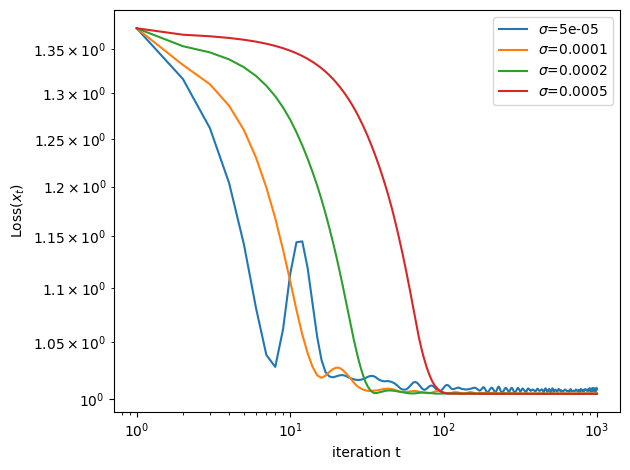

In [4]:
for isig in range(nsig):
    plt.plot(1+np.arange(niter),loss_xt[:,isig],label=r'$\sigma$'+'='+str(sig_grid[isig]))
plt.legend(loc='upper right')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Loss'+r'$(x_t)$')
plt.xlabel('iteration t')
plt.tight_layout()
plt.show()

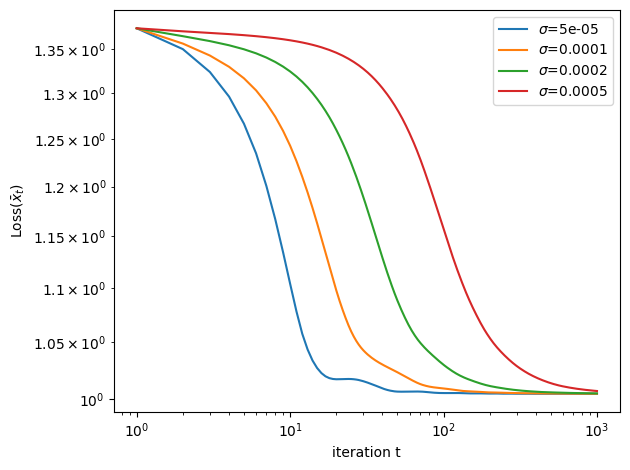

In [5]:
for isig in range(nsig):
    plt.plot(1+np.arange(niter),loss_xtbar[:,isig],label=r'$\sigma$'+'='+str(sig_grid[isig]))
plt.legend(loc='upper right')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Loss'+r'$(\bar{x}_t)$')
plt.xlabel('iteration t')
plt.tight_layout()
plt.show()


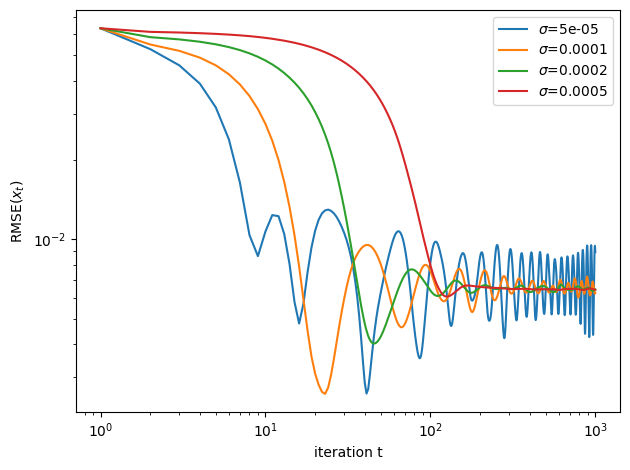

In [6]:
for isig in range(nsig):
    plt.plot(1+np.arange(niter),rmse_xt[:,isig],label=r'$\sigma$'+'='+str(sig_grid[isig]))
plt.legend(loc='upper right')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('RMSE'+r'$(x_t)$')
plt.xlabel('iteration t')
plt.tight_layout()
plt.show()

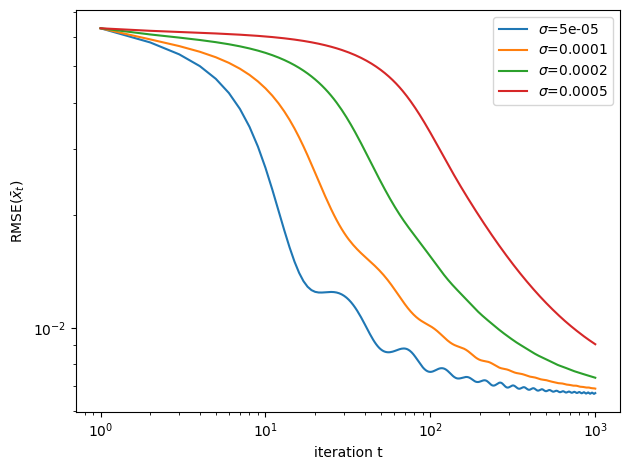

In [7]:
for isig in range(nsig):
    plt.plot(1+np.arange(niter),rmse_xtbar[:,isig],label=r'$\sigma$'+'='+str(sig_grid[isig]))
plt.legend(loc='upper right')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('RMSE'+r'$(\bar{x}_t)$')
plt.xlabel('iteration t')
plt.tight_layout()
plt.show()